# Load files and images

In [21]:
import json

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms as transforms
from PIL import Image
from scipy.ndimage import gaussian_filter
from torch.utils.data import Dataset, DataLoader

In [2]:
# DIRECTORIES
annotations_dir_train = './annotations/person_keypoints_train2017.json'
images_dir_train = './train2017/'

annotations_dir_val = './annotations/person_keypoints_val2017.json'
images_dir_val = './val2017/'

In [3]:
# Read the json file and extract the annotations data for all images
def read_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

json_train_data = read_json(annotations_dir_train)
json_validation_data = read_json(annotations_dir_val)

In [4]:
# SET GPU AS DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Clean train data
clean_annotations = []
for each_annot in json_train_data['annotations']:
    # Checks if the picture shows more than one person
    if each_annot['iscrowd'] != 0:
        continue
    # Checks if the picture has annotations
    if each_annot['num_keypoints'] < 1:
        continue
        
    # Check if the picture has a big enough box
    if each_annot['bbox'][2] < 48 and each_annot['bbox'][3] < 64:
        continue
        
    clean_annotations.append(each_annot)  

In [6]:
print("Total entries in original data: {}".format(len(json_train_data['annotations'])))
print("Total entries in cleaned data: {}".format(len(clean_annotations)))

Total entries in original data: 262465
Total entries in cleaned data: 144577


# Transforms

Original image shape: (426, 640)
Resized image shape: 147456
Image as array: (256, 192, 3)
Final tensor shape:torch.Size([3, 256, 192]) min:-2.12 max:2.36


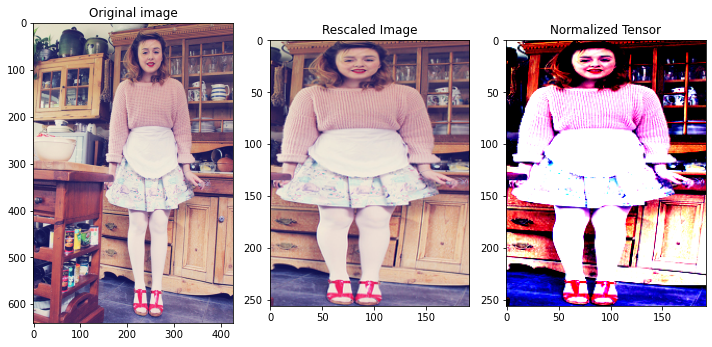

In [9]:
annotation = clean_annotations[100]
img_name = '000000000000'
img_name = img_name[0:len(img_name) - len(str(annotation['image_id']))] + str(annotation['image_id']) + '.jpg'
pil_image = Image.open(images_dir_train + '/' + img_name)

x, y, w, h = annotation['bbox']
resized_img = pil_image.resize((192, 256), box=(x, y, x + w, y + h))

array = np.array(resized_img)

# Add on more dimension in case image is Black & White
if len(array.shape) != 3:
#     array = np.stack((array, )*3, axis=-1)
    array = np.atleast_3d(array)


mean=np.asarray([0.485, 0.456, 0.406])
std=np.asarray([0.229, 0.224, 0.225])

transformations = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(mean=mean, std=std)])
                                      
rescaled_img = array / 255.
tensor_image = transformations(rescaled_img)


print("Original image shape: {}".format(pil_image.size))
print("Resized image shape: {}".format(rescaled_img.size))
print("Image as array: {}".format(array.shape))
print("Final tensor shape:{} min:{:.2f} max:{:.2f}".format(tensor_image.shape, tensor_image.min(), tensor_image.max()))


fig, ax = plt.subplots(ncols=3, figsize=(10,5))
ax[0].imshow(np.array(pil_image))
ax[0].set_title("Original image")

ax[1].imshow(array)
ax[1].set_title("Rescaled Image")

ax[2].imshow(np.clip(tensor_image.permute(1,2,0).numpy(), 0, 1))
ax[2].set_title("Normalized Tensor")

plt.tight_layout()
plt.show()

# Heatmaps

In [10]:
keypoints_names = json_train_data['categories'][0]['keypoints']
keypoints = np.array(annotation['keypoints']).reshape(17,3)
keypoints_dict = {name: k for (name, k) in zip(keypoints_names, keypoints)}

In [11]:
keypoints_dict

{'nose': array([250,  69,   2]),
 'left_eye': array([263,  60,   2]),
 'right_eye': array([238,  63,   2]),
 'left_ear': array([274,  71,   2]),
 'right_ear': array([221,  73,   2]),
 'left_shoulder': array([293, 127,   2]),
 'right_shoulder': array([206, 132,   2]),
 'left_elbow': array([315, 225,   2]),
 'right_elbow': array([182, 227,   2]),
 'left_wrist': array([328, 304,   2]),
 'right_wrist': array([167, 320,   2]),
 'left_hip': array([282, 287,   2]),
 'right_hip': array([219, 285,   2]),
 'left_knee': array([268, 423,   2]),
 'right_knee': array([219, 426,   2]),
 'left_ankle': array([262, 562,   2]),
 'right_ankle': array([227, 562,   2])}

In [12]:
heatmap_w = 48
heatmap_h = 64
rescaled_keypoints = np.ceil((keypoints - [x, y, 0]) * (np.array([heatmap_w, heatmap_h, 1]) / np.array([w, h, 1])) ).astype(np.int)

In [13]:
rescaled_keypoints

array([[22,  6,  2],
       [24,  5,  2],
       [19,  5,  2],
       [27,  6,  2],
       [16,  6,  2],
       [31, 12,  2],
       [13, 13,  2],
       [35, 22,  2],
       [ 8, 23,  2],
       [38, 31,  2],
       [ 5, 32,  2],
       [28, 29,  2],
       [15, 29,  2],
       [25, 43,  2],
       [15, 43,  2],
       [24, 58,  2],
       [17, 58,  2]])

In [14]:
heatmaps = np.zeros((17, 64, 48))
for i in range(17):
    if rescaled_keypoints[i][2] > 0:
        temp_x = rescaled_keypoints[i][1]
        temp_y = rescaled_keypoints[i][0]
        heatmaps[i, temp_x, temp_y] = 1.0
        heatmaps[i, :, :] = gaussian_filter(heatmaps[i, :, :], sigma=2, mode='constant', cval=0.0)
        heatmaps[i, :, :] = (heatmaps[i, :, :] - np.min(heatmaps[i, :, :])) / (np.max(heatmaps[i, :,:]) - np.min(heatmaps[i, :, :]))
        
validity = [1 if v > 0 else 0 for v in rescaled_keypoints[:,2]]   


validity_tensor = torch.tensor(validity).float()
heatmaps_tensor = torch.tensor(heatmaps).float()

In [15]:
validity_tensor.unsqueeze(1).unsqueeze(1).shape

torch.Size([17, 1, 1])

# MAKE THE MODEL CLASS

In [16]:
import torch.nn as nn

from calculate_accuracy import *


# Build the network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.checkpoint_path = 'model_checkpoints'

        # 1st CONVOLUTION, IN_CHANNELS = 3 (RGB), OUT_CHANNELS=64, KERNEL=7x7, STRIDE=2, PADDING=3
        self.Conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        nn.init.xavier_normal_(self.Conv1.weight)
        nn.init.constant_(self.Conv1.bias, 0)
        # END 1st CONVOLUTION, OUT_CONV_SHAPE = [(192−7+2*3)/2]+1=[96, 128]

        # 1st SEQUENTIAL LAYER
        self.layer1 = nn.Sequential(
            self.Conv1,
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # END 1st SEQUENTIAL, OUT_MAX_POOL_SHAPE = [96, 128] / 2 = [48, 64]

        # 2nd CONVOLUTION, IN_CHANNELS=64, OUT_CHANNELS=128, KERNEL=5x5, STRIDE=1, PADDING=2
        self.Conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        nn.init.xavier_normal_(self.Conv2.weight)
        nn.init.constant_(self.Conv2.bias, 0)
        # END 2nd CONVOLUTION, OUT_CONV_SHAPE = [(48−5+2*2)/1]+1=[48, 64]

        # 2nd SEQUENTIAL LAYER
        self.layer2 = nn.Sequential(
            self.Conv2,
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # END 2nd SEQUENTIAL, OUT_MAX_POOL_SHAPE = [48, 64] / 2 = [24, 32]

        # 3rd CONVOLUTION, IN_CHANNELS=128, OUT_CHANNELS=256, KERNEL=5x5, STRIDE=1, PADDING=2
        self.Conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2)
        nn.init.xavier_normal_(self.Conv3.weight)
        nn.init.constant_(self.Conv3.bias, 0)
        # END 3rd CONVOLUTION, OUT_CONV_SHAPE = [(24−5+2*2)/1]+1=[24, 32]

        # 3rd SEQUENTIAL LAYER
        self.layer3 = nn.Sequential(
            self.Conv3,
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # END 2nd SEQUENTIAL, OUT_MAX_POOL_SHAPE = [24, 32] / 2 = [12, 16]

        # Deconvolution
        self.deconv4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, padding=1, output_padding=0, kernel_size=4,
                                          stride=2)
        nn.init.xavier_normal_(self.deconv4.weight)
        self.layer4 = nn.Sequential(
            self.deconv4,
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Deconvolution
        self.deconv5 = nn.ConvTranspose2d(in_channels=256, out_channels=256, padding=1, output_padding=0, kernel_size=4,
                                          stride=2)
        nn.init.xavier_normal_(self.deconv5.weight)
        self.layer5 = nn.Sequential(
            self.deconv5,
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # FINAL CONVOLUTION, IN_CHANNELS=256, OUT_CHANNELS=17, KERNEL=1x1, STRIDE=1, PADDING=0
        self.final_conv = nn.Conv2d(in_channels=256, out_channels=17, kernel_size=1)
        nn.init.xavier_normal_(self.final_conv.weight)
        nn.init.constant_(self.final_conv.bias, 0)
        # END FINAL CONVOLUTION, OUT_CONV_SHAPE = [(24−1+2*0)/1]+1=[24, 32]

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.final_conv(out)

        return out

    # Loss function
    @staticmethod
    def custom_l2_loss_closure(mse_loss_fn):
        # We want to zero out the loss for when no label was provided in the target heatmap
        # We can achieve this by multiply the validity tensor with the pred

        def custom_l2_loss(pred, target, validity):
            v = validity.unsqueeze(2).unsqueeze(2)
            pred = pred * v
            target = target * v
            return mse_loss_fn(pred, target)

        return custom_l2_loss

    # function to store model checkpoint
    def checkpoint_model(self, optimizer, epoch, batch):
        state = {'model': self.state_dict(), 'optimizer': optimizer.state_dict()}
        torch.save(state, self.checkpoint_path + "_posenet_" + str(epoch) + "_" + str(batch) + '.pth')

    def fit(self, epochs, train_dataloder, val_dataloader, optimizer, loss_fn, scheduler):
        for j in range(epochs):
            for i_batch, sample_batched in enumerate(train_dataloder):

                input_img = sample_batched['image'].to('cuda')
                heatmap = sample_batched['heatmap'].to('cuda')
                validity = sample_batched['validity'].to('cuda')

                # Clear out accumulated gradients
                optimizer.zero_grad()

                output = self(input_img)
                loss = loss_fn(output, heatmap, validity)

                loss.backward()
                optimizer.step()

                if i_batch % 500 == 0:
                    acc_train = accuracy(output.detach().cpu().numpy(), heatmap.detach().cpu().numpy())
                    acc_val = get_accuracy(self, val_dataloader)
                    print("Epoch\t", j, "Batch\t", i_batch, "Training Loss: \t", loss.item(), "Train Accuracy: \t",
                          acc_train,
                          "Val Accuracy: \t", acc_val)

                if i_batch % 5000 == 0:
                    self.checkpoint_model(optimizer, j, i_batch)

            scheduler.step()
        self.checkpoint_model(optimizer, j, i_batch)


# DATASET

In [17]:
import json

import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from scipy.ndimage import gaussian_filter
from torch.utils.data import Dataset


# =============================================================================
# DATASET CLASS
# =============================================================================
class AnnotationsDataset(Dataset):

    def __init__(self, annotations_path, img_dir):
        self.annotations_path = annotations_path
        self.img_dir = img_dir
        self.data = self.read_json(self.annotations_path)
        self.annotations = self.data['annotations']
        # Clean annotations
        self.clean_annotations = self.clean_data()

    @staticmethod
    def read_json(path):
        with open(path, 'r') as f:
            data = json.load(f)
        return data

    def clean_data(self):
        clean_annotations = []
        for each_annot in self.annotations:
            # Checks if the picture shows more than one person
            if each_annot['iscrowd'] != 0:
                continue
            # Checks if the picture has annotations
            if each_annot['num_keypoints'] < 1:
                continue

            # Check if the picture has a big enough box
            if each_annot['bbox'][2] < 48 and each_annot['bbox'][3] < 64:
                continue

            clean_annotations.append(each_annot)

        return clean_annotations

    def load_image(self, annotation):
        img_name = '000000000000'
        img_name = img_name[0:len(img_name) - len(str(annotation['image_id']))] + str(annotation['image_id']) + '.jpg'
        pil_image = Image.open(self.img_dir + '/' + img_name)

        x, y, w, h = annotation['bbox']
        resized_img = pil_image.resize((192, 256), box=(x, y, x + w, y + h))
        array = np.array(resized_img)

        # Add on more dimension in case image is Black & White
        if len(array.shape) != 3:
            array = np.stack((array,) * 3, axis=-1)
        #     array = np.atleast_3d(array)

        transformations = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                   std=[0.229, 0.224, 0.225])])
        rescaled_img = array / 255.
        tensor_image = transformations(rescaled_img).float()

        return tensor_image

    @staticmethod
    def heatmaps(annotation):
        keypoints = np.array(annotation['keypoints']).reshape(17, 3)
        x, y, w, h = annotation['bbox']
        heatmap_w = 48
        heatmap_h = 64
        rescaled_keypoints = np.ceil(
            (keypoints - [x, y, 0]) * (np.array([heatmap_w, heatmap_h, 1]) / np.array([w, h, 1]))).astype(np.int)

        heatmaps = np.zeros((17, 64, 48))
        for i in range(17):
            if rescaled_keypoints[i][2] > 0:

                temp_x = rescaled_keypoints[i][1]
                temp_y = rescaled_keypoints[i][0]

                if temp_x >= 64 or temp_y >= 48 or temp_x < 0 or temp_y < 0:
                    rescaled_keypoints[i][2] = 0
                    continue
                else:
                    heatmaps[i, temp_x, temp_y] = 1.0
                    heatmaps[i, :, :] = gaussian_filter(heatmaps[i, :, :], sigma=2, mode='constant', cval=0.0)
                    heatmaps[i, :, :] = (heatmaps[i, :, :] - np.min(heatmaps[i, :, :])) / (
                            np.max(heatmaps[i, :, :]) - np.min(heatmaps[i, :, :]))

        validity = [1 if v > 0 else 0 for v in rescaled_keypoints[:, 2]]

        validity_tensor = torch.tensor(validity).float()
        heatmaps_tensor = torch.tensor(heatmaps).float()

        return heatmaps_tensor, validity_tensor

    def __len__(self):
        return len(self.clean_annotations)

    def __getitem__(self, id):
        annotation = self.annotations[id]
        image = self.load_image(annotation)
        heatmap, validity = self.heatmaps(annotation)

        return {'image': image, 'heatmap': heatmap, 'validity': validity}

In [18]:
# DATASETS
train_dataset = AnnotationsDataset(annotations_path='./annotations/person_keypoints_train2017.json',
                                   img_dir='./train2017')
val_dataset = AnnotationsDataset(annotations_path='./annotations/person_keypoints_val2017.json',
                                 img_dir='./val2017')

In [19]:
# DATA LOADER
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0)

# LOAD MODEL WEIGTHS AND MAKE PREDICTIONS

In [25]:
# Make a model instance
model = ConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Load the checpoints
checkpoint = torch.load('model_checkpoints/old/model_checkpointsposenet_9_9036.pth')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [79]:
sample = iter(train_dataloader).next()

In [80]:
model.eval()
input_img = sample['image'][None,0].to('cuda')
heatmap = sample['heatmap'][None,0].to('cuda')
validity = sample['validity'][None,0].to('cuda')
with torch.no_grad():
    output = model(input_img)


In [81]:
# Denormalize the images again to better view them
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

unorm_image=invTrans(input_img[0,:,:,:])

In [82]:
img_c = (unorm_image.squeeze(0).permute(1,2,0).to('cpu').numpy())
heatmap_c =heatmap.squeeze(0).sum(axis=0).to('cpu').numpy()
validity_c = validity.to('cpu').numpy()

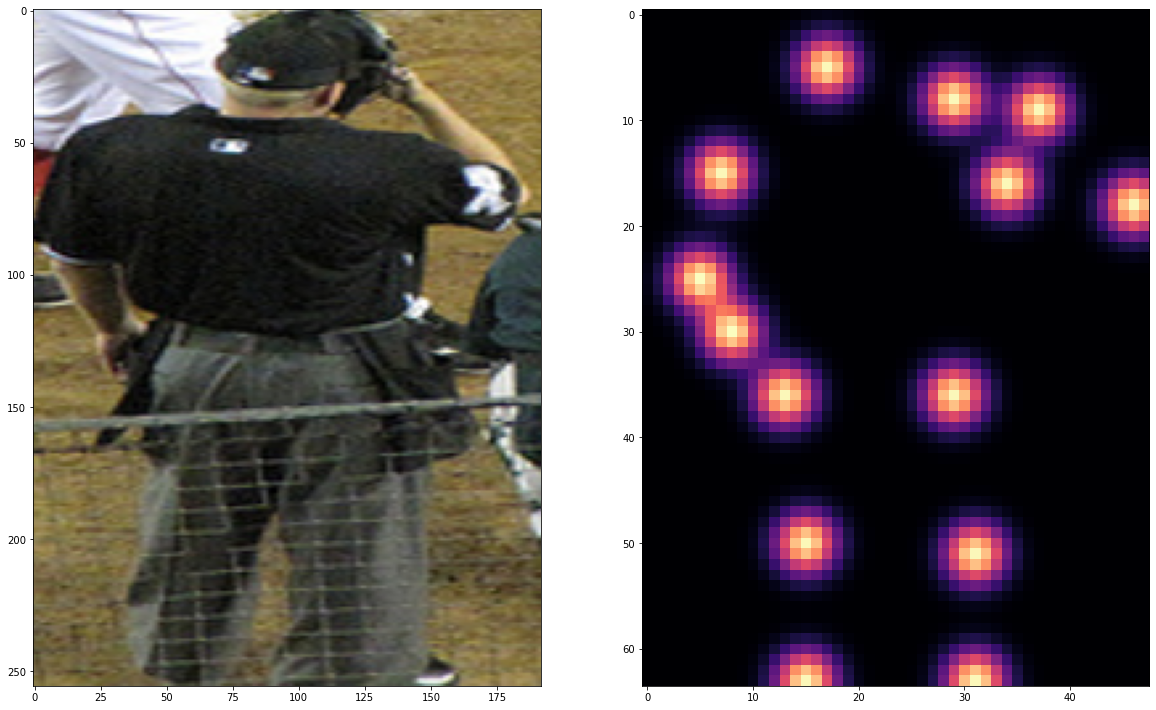

In [83]:
# plot data
fig = plt.figure(2,figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(img_c)
ax2 = fig.add_subplot(122)
ax2.imshow(heatmap_c, cmap='magma')
plt.show()

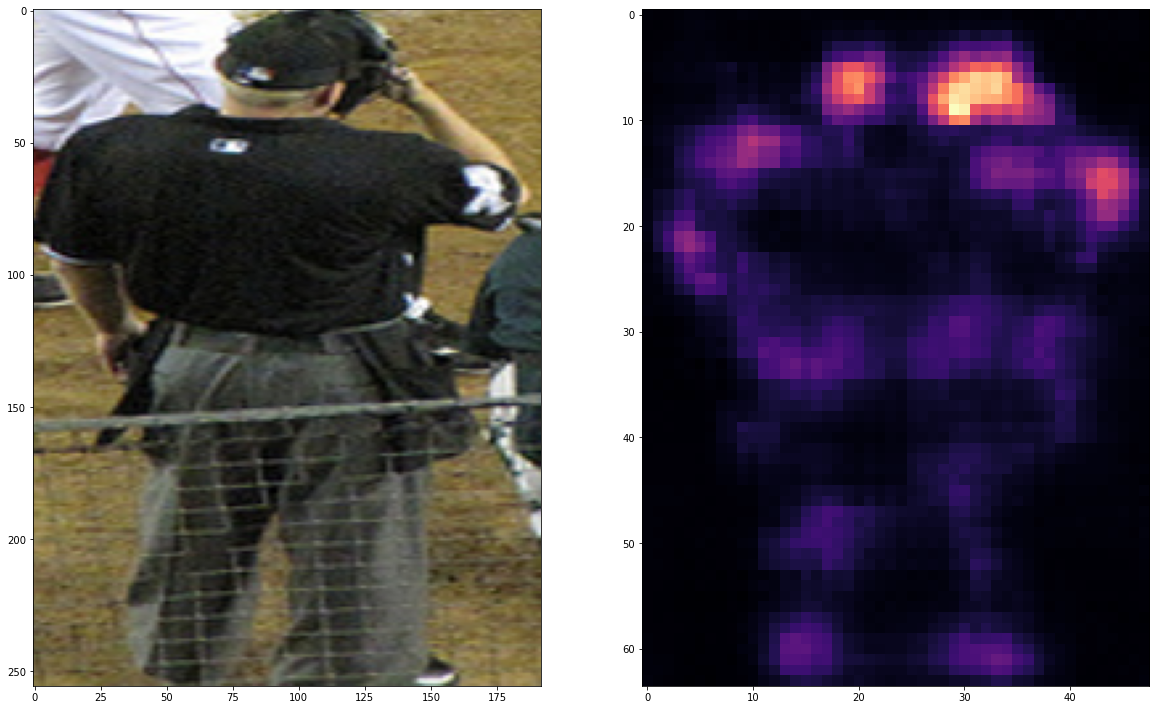

In [84]:
# plot data
heatmap_p =output.squeeze(0).sum(axis=0).to('cpu').numpy()
fig = plt.figure(2,figsize=(20,20)) # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax1.imshow(img_c)
ax2 = fig.add_subplot(122)  # right side
ax2.imshow(heatmap_p, cmap='magma')
plt.show()